# NLP with Disaster Tweets

In [1]:
import pandas as pd                                 # Pandas for DataFrame
from matplotlib import pyplot as plt                # Matplotlib for plots
from sklearn.preprocessing import LabelEncoder
import spacy                                        # Spacy for text processing
import seaborn as sns 

nlp = spacy.load('en_core_web_sm')                  # Load the English language (Options: en_core_web_sm, en_core_web_md, en_core_web_lg)

## Load the data and getting basic idea

In [20]:
# drive_data_root = '/content/drive/MyDrive/Kaggle/NLP-with-Disaster-Tweets/Data/Raw'
local_root = 'Data/Raw'

# Load data from path.
train_df = pd.read_csv(f'{local_root}/train.csv')
test_df = pd.read_csv(f'{local_root}/test.csv')

# Data head
train_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [18]:
# Data shape
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns for "train_df".')
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns for "test_df".')

There are 7613 rows and 5 columns for "train_df".
There are 3263 rows and 4 columns for "test_df".


## Exploratory Data Analysis (EDA)
In this step we explore and investigations the following some of the aspects of our datasets. Namely we examine the following ideas:

- Check the usefulness of 'id' column regarding 'target'.
- Preprocessing steps required for the text.
- Possible Feature Extractions of the text.
- Explore 'location' and 'keyword' columns, find their distributions and relations with the 'target'.

### Target feature
About 57.0% are "0" and around 43.0% are "1". Targets are almost equaly distributed. Since there are only two classes, this is a binary classification problem.

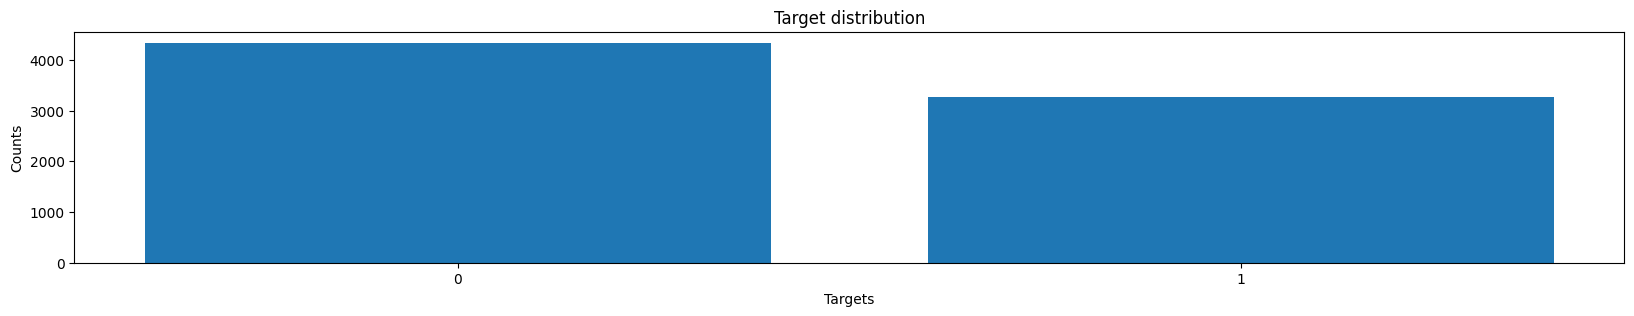

In [48]:
# Check the distribution of tagets
target_counts = train_df['target'].value_counts()

fig = plt.figure(figsize = (20, 3))
plt.title('Target distribution')
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.xticks([0, 1])
plt.bar(target_counts.keys(), target_counts.values)
plt.show()

### Location feature
After careful investigation of the 'location' column, we can take note that:
- Some countries, although the same, have different naming convensions (eg. USA, United states)
- There are some formatting errors (eg. T E X A S)
- 33% of the locations are missing!
- Around 44% of the locations in the dataset are unique. That is a good sign!

- There are 2533 missing entries on "location" column (33.3%)
- Number of unique locations: 3342 (43.9%)


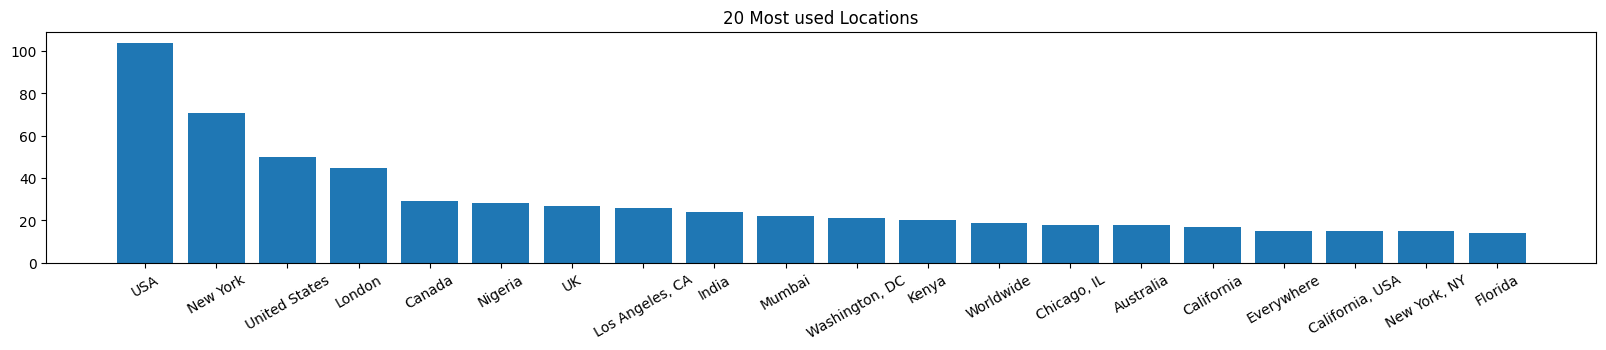

In [49]:
# NULL entries
null_entries = train_df.loc[train_df['location'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "location" column ({round(null_entries_count / train_df.shape[0] * 100, 1)}%)')

# Uniqueness
unique_locations = train_df['location'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique locations: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 20 Top Frequencies
location_freq = train_df['location'].value_counts()
top_20_locs = location_freq[:20]

fig = plt.figure(figsize = (20, 3))
plt.title('20 Most used Locations')
plt.bar(top_20_locs.index, top_20_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Keyword
We understand the followings from a quick analysis of the keywords:
- Most keywords contain space which is represented by '%20'
- Most keywords indicate distaster signs according to our graph. Good sign here!
- Only about 3% of the keywords are unique. This can be a potencially good feature to base the classification on.

- There are 61 missing entries on "keyword" column (0.8%)
Number of unique keyword: 222 (2.92%)


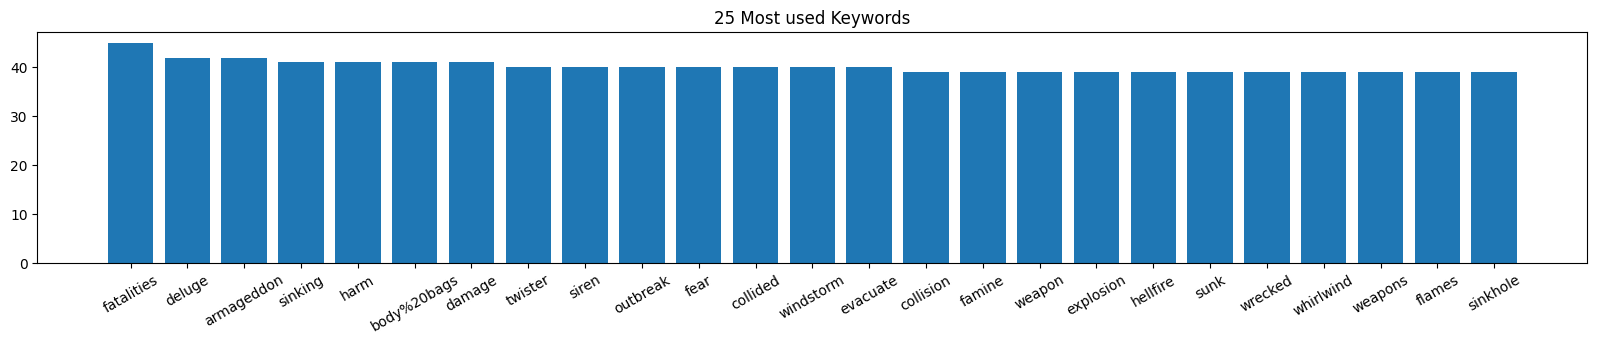

In [4]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 2t Top Frequencies
keyword_freq = train_df['keyword'].value_counts()
keys_25_locs = keyword_freq[:25]

fig = plt.figure(figsize = (20, 3))
plt.title('25 Most used Keywords')
plt.bar(keys_25_locs.index, keys_25_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Text feature
For the sake of educational purposes, I am going to extract as much information as I can from the text, this includes extracting links, hashtags and mentions and
anything that can be considered useful. Some of the task we are going to be doing:
- There are lot's of #hashtags used that can be helpful, so extract the hashtags and store them in a list for each tweet.
- There also are some links, extract them and save the root url for each tweet.
- @mentions can be seen in some tweets, maybe they point to a certain user or something, extract the username and store it in a list for each tweet.
- There are some emojies and None-ASCII characters that are better be removed.
- Numbers can also be removed as they may be a little misleading.
- Some comments are written in uppercase, we may want to make them lowercase.
- There are comments that are almost identical except their links, we can easily detect and remove the duplicates after extracting links (See text[110:120])

Some aspects to analyze:
- With a quick glance of the data, it can be seen that the numebr of words/characters used in each tweet can be very useful as non-disaster tweets are often shorter.
- Maybe finding the common words can be useful for identifing which class does each tweet belong to.

In [63]:
list(train_df['text'].iloc[105:110].values)

["'There is no victory at bargain basement prices.' Dwight David Eisenhower",
 '320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #Ices\x89Û_ http://t.co/zEVakJaPcz',
 "'Nobody remembers who came in second.' Charles Schulz",
 '@afterShock_DeLo im speaking from someone that is using a scuf on xb1 most of them people will end up getting on for ps also.',
 "'The harder the conflict the more glorious the triumph.' Thomas Paine"]